In [4]:
import casadi
import numpy as np
from IPython.display import HTML
from multi_mpc_unicycle import  MPC_CBF_Unicycle
from multi_mpc_unicycle import  dm_to_array
from multi_mpc_unicycle import animate

from shapely.geometry import Polygon, Point
from voronoi import voronoicentroid
from bearing_rigidity_utils import create_adjacency_matrix, get_neighbors_state, get_neighbors_bearing, generate_random_laman_graph
from coverage_utils import calculate_locational_opt_cost
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MPC with Bearing Rigidity, \mu = 1000 

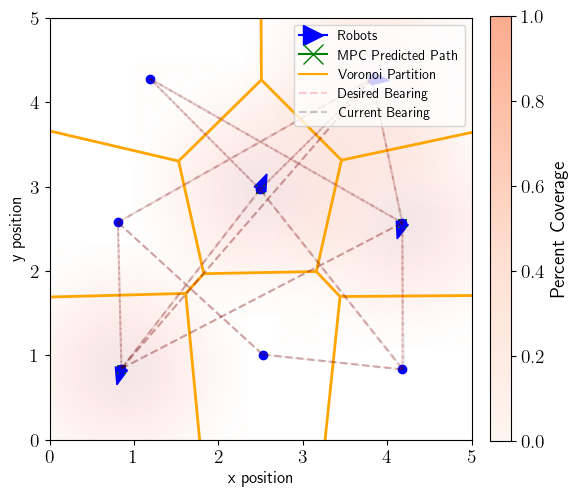

In [13]:
Q_x = 1
Q_y = 1
Q_theta = 1
R_v = 0.5
R_omega = 0.005

dt = 0.1
N = 20

v_lim = [-0.4, 0.4]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]

workspace = Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])

n_agents = 8
n_neighbors = np.zeros(n_agents, dtype=int)

# # Set Neighbors
# edges = [[0,1], [0,3], [0,2],
#            [1,2], [2,3] ] # these edges are undirected
# adj_matrix = create_adjacency_matrix(edges)

adj_matrix = generate_random_laman_graph(n_agents)
#agents_init_state = np.array([[0.7, 0.9, 0.0], [0.5, 1.2, 0.0], [2.0, 1.5, 0.0], [1.5, 1.0, 0.0] ])
agents_init_state = 5*np.random.rand(n_agents, 3)

for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if (adj_matrix[i][j]==1):
            n_neighbors[i]+=1         

t0_list = [0 for i in range(n_agents)]
agents = [MPC_CBF_Unicycle(agents_init_state[i], n_neighbors[i], dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False, mu=1000) for i in range(n_agents)]
ref_state_list = []

state_0_list = [casadi.DM([agents_init_state[i][0], agents_init_state[i][1], agents_init_state[i][2]]) for i in range(n_agents)]
u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]

u_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
X_pred_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
agents_state_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
agents_control_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]
max_iter = 100

vor_list = []
vcentroids_list = []

p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
vcentroids, vor = voronoicentroid(p, workspace)
vor_list.append(vor)
vcentroids_list.append(vcentroids)    
max_iter = 30
max_time = 5

cost_mu_1000 = []
for k in range(max_iter):
    ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]    
    for t in range(max_time):
        agent_states = np.array([agents[i].states for i in range(n_agents)])
        cost_= calculate_locational_opt_cost(agent_states[:, :2], [0,5] , [0,5], 100)
        cost_mu_1000.append(cost_)
        for j in range(n_agents):
            neighbor_states = get_neighbors_state(j, agent_states, adj_matrix)
            curr_bearing = get_neighbors_bearing(agent_states[j], neighbor_states)
            agent_target_state = ref_states_list[j][0]
            neighbor_target_states = get_neighbors_state(j, agent_states, adj_matrix)
            target_bearing = get_neighbors_bearing(agent_target_state, neighbor_target_states)
            u_list[j], X_pred_list[j] = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t, neighbor_states, target_bearing)

        for j in range(n_agents):
            agents_state_list[j] = np.dstack((agents_state_list[j], dm_to_array(X_pred_list[j])))
            agents_control_list[j] = np.dstack((agents_control_list[j], dm_to_array(u_list[j][:, 0])))
            t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred_list[j], u_list[j])

    p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    
anim_params = {
    'ref_state_list': ref_state_list,
    'agents_init_state':agents_init_state,
    'agents_state_list':agents_state_list,
    'agents_control_list':agents_control_list,
    'obstacles': None,
    'num_frames':max_iter*max_time,
    'max_iter':max_iter,
    'pred_horizon':N,
    'adj_matrix':adj_matrix,
    'vor':vor_list,
    'vcentroids': vcentroids_list,
    'save': False,
    'file_name':'coverage_with_bearing.mp4'
    
}
sim = animate(anim_params)

HTML(sim.to_html5_video())  

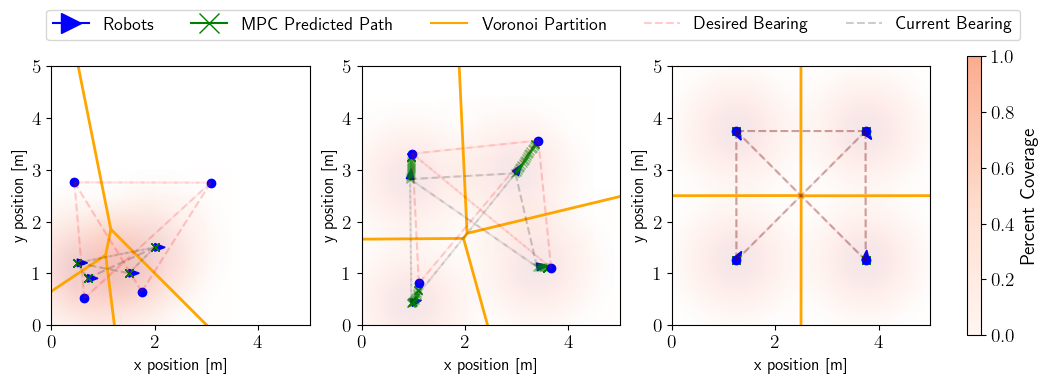

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from scipy.spatial import voronoi_plot_2d

mpl.rcParams['font.size'] = 14
mpl.rcParams['text.usetex'] = True

ref_state_list = anim_params['ref_state_list']
agents_init_state = anim_params['agents_init_state']
agents_state_list = anim_params['agents_state_list']
agents_control_list = anim_params['agents_control_list'] 
obstacles = anim_params['obstacles']
num_frames = anim_params['num_frames']
max_iter = anim_params['max_iter']
pred_horizon = anim_params['pred_horizon'] 
vor = anim_params['vor']
vcentroids = anim_params['vcentroids']
save = anim_params['save'] 
adj_matrix = anim_params['adj_matrix']

def create_triangle(state=[0,0,0], h=0.2, w=0.15, update=False):
        x, y, th = state
        triangle = np.array([
            [h, 0   ],
            [0,  w/2],
            [0, -w/2],
            [h, 0   ]
        ]).T
        rotation_matrix = np.array([
            [np.cos(th), -np.sin(th)],
            [np.sin(th),  np.cos(th)]
        ])
        coords = np.array([[x, y]]) + (rotation_matrix @ triangle).T
        if update == True:
            return coords
        else:
            return coords[:3, :]


# Function to create a gradient-filled circle
def radial_gradient_circle(ax, center_x, center_y, radius, colormap='viridis'):
    """
    Creates a radial gradient circle.
    """
    # Create a meshgrid for the circle
    x, y = np.meshgrid(np.linspace(center_x - radius, center_x + radius, 100),
                    np.linspace(center_y - radius, center_y + radius, 100))
    # Calculate the distance from the center for each point
    r = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    # Normalize the distance to be between 0 and 1
    r = np.clip(r, 0, radius) / radius
    # Create a colormap
    cmap = plt.get_cmap(colormap).reversed()
    # Map the distance to the colormap
    colors = cmap(r)
    # Plot the circle
    ax.imshow(colors, extent=[center_x - radius, center_x + radius, center_y - radius, center_y + radius], alpha=0.1)
    # Set aspect to 'equal' to ensure the circle looks circular
    ax.set_aspect('equal')



# create figure and axes
n_agents = 4
fig, ax = plt.subplots(1,3, figsize=(12, 6))
# create lines:
#   path
path_list = []
ref_path_list = []
horizon_list = []
current_state_list = []

indexes = [0, 50, 149]
for i, idx in enumerate(indexes):
    for k in range(n_agents):
        # get variables
        x = agents_state_list[k][0, 0, idx]
        y = agents_state_list[k][1, 0, idx]
        th = agents_state_list[k][2, 0, idx]
        
        # update horizon
        x_new = agents_state_list[k][0, :, idx]
        y_new = agents_state_list[k][1, :, idx]
        horizon, = ax[i].plot(x_new, y_new, 'x-g', alpha=0.5)
        
        current_triangle = create_triangle([x, y, th])
        current_state = ax[i].fill(current_triangle[:, 0], current_triangle[:, 1], color='b')
        current_state = current_state[0]

        # Draw a transparent circle
        radial_gradient_circle(ax[i], x, y, radius=1.5, colormap='Reds')

  
    den = num_frames/max_iter
    # Show Centroids
    for vcentroid in vcentroids[int(idx/den)]:
        ax[i].plot(vcentroid[0], vcentroid[1], 'o', color='blue')

    voronoi_plot_2d(vor[int(idx/den)], ax=ax[i], show_vertices=False, show_points = False, line_colors='orange', line_width=2)
    for j in range(adj_matrix.shape[0]):
        for k in range(adj_matrix.shape[1]):
            if (adj_matrix[j][k]==1):
                centroid_1 = vcentroids[int(idx/den)][j]
                centroid_2 = vcentroids[int(idx/den)][k]
                x = [centroid_1[0], centroid_2[0]]
                y = [centroid_1[1], centroid_2[1]]
                ax[i].plot(x, y, '--r', alpha=0.1)
        
            

    ax[i].set_xlim(0,5)
    ax[i].set_ylim(0,5)
    ax[i].set_xlabel('x position [m]', fontsize =12)
    ax[i].set_ylabel('y position [m]', fontsize =12)
    ax[i].set_rasterized(True)
       
    for j in range(adj_matrix.shape[0]):
        for k in range(adj_matrix.shape[1]):
            if (adj_matrix[j][k]==1):
                state_agent_1 = agents_state_list[j][:, 0, idx]
                state_agent_2 = agents_state_list[k][:, 0, idx]
                x = [state_agent_1[0], state_agent_2[0]]
                y = [state_agent_1[1], state_agent_2[1]]
                ax[i].plot(x, y, '--k', alpha=0.1)


legend_elements = [ Line2D([0], [0], marker='>', color='b', markerfacecolor='b', markersize=15, label='Robots'),
                    Line2D([0], [0], marker='x',color='g', markerfacecolor='g', markersize=15,label='MPC Predicted Path',),
                    Line2D([0], [0], linestyle='-',color='orange', markerfacecolor='r', markersize=15,label='Voronoi Partition',),
                    Line2D([0], [0], linestyle='--',color='r', markerfacecolor='r', markersize=15, alpha = 0.2, label='Desired Bearing',),
                    Line2D([0], [0], linestyle='--',color='k', markerfacecolor='k', markersize=15,alpha = 0.2, label='Current Bearing',),
                ]
# plt.tight_layout()
fig.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=[0.94, 0.82],  fontsize = 13, ncol=5)  
red_cmp = plt.get_cmap('Reds', 256)
red_cmp = ListedColormap(red_cmp(np.linspace(0, 0.3, 256)))

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=red_cmp),
            ax=ax, orientation='vertical',fraction=0.015, pad=0.04, label='Percent Coverage')

    
plt.savefig('coverage.pdf')
plt.show()

# Locational Optimization Cost Comparison with and without Bearing Rigidity

In [ ]:
Q_x = 1
Q_y = 1
Q_theta = 1
R_v = 0.5
R_omega = 0.005

dt = 0.1
N = 20

v_lim = [-0.4, 0.4]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]

workspace = Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])

n_agents = 4
cost_mu_0_arr = []
cost_mu_1000_arr = []

for i in tqdm(range(1000)):
    n_neighbors = np.zeros(n_agents, dtype=int)
    adj_matrix = generate_random_laman_graph(n_agents)
    agents_init_state = 5*np.random.rand(n_agents, 3)
    #agents_init_state = np.array([[0.7, 0.9, 0.0], [0.5, 1.2, 0.0], [2.0, 1.5, 0.0], [1.5, 1.0, 0.0] ])

    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if (adj_matrix[i][j]==1):
                n_neighbors[i]+=1         

    t0_list = [0 for i in range(n_agents)]

    agents = [MPC_CBF_Unicycle(agents_init_state[i], n_neighbors[i], dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False, mu=0) for i in range(n_agents)]

    state_0_list = [casadi.DM([agents_init_state[i][0], agents_init_state[i][1], agents_init_state[i][2]]) for i in range(n_agents)]
    u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]

    u_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X_pred_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
    agents_state_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
    agents_control_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]
    max_iter = 100

    vor_list = []
    vcentroids_list = []

    p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    
    max_iter = 30
    max_time = 5

    cost_mu_0 = []
    for k in range(max_iter):
        ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]    
        for t in range(max_time):
            agent_states = np.array([agents[i].states for i in range(n_agents)])
            cost_= calculate_locational_opt_cost(agent_states[:, :2], [0,5] , [0,5], 100)
            cost_mu_0.append(cost_)
            for j in range(n_agents):
                neighbor_states = get_neighbors_state(j, agent_states, adj_matrix)
                curr_bearing = get_neighbors_bearing(agent_states[j], neighbor_states)
                agent_target_state = ref_states_list[j][0]
                neighbor_target_states = get_neighbors_state(j, agent_states, adj_matrix)
                target_bearing = get_neighbors_bearing(agent_target_state, neighbor_target_states)
                u_list[j], X_pred_list[j] = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t, neighbor_states, target_bearing)

            for j in range(n_agents):
                agents_state_list[j] = np.dstack((agents_state_list[j], dm_to_array(X_pred_list[j])))
                agents_control_list[j] = np.dstack((agents_control_list[j], dm_to_array(u_list[j][:, 0])))
                t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred_list[j], u_list[j])

        p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
        vcentroids, vor = voronoicentroid(p, workspace)
        
        vor_list.append(vor)
        vcentroids_list.append(vcentroids) 
    cost_mu_0_arr.append(cost_mu_0)  

    
    
    agents = [MPC_CBF_Unicycle(agents_init_state[i], n_neighbors[i], dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False, mu=1000) for i in range(n_agents)]

    state_0_list = [casadi.DM([agents_init_state[i][0], agents_init_state[i][1], agents_init_state[i][2]]) for i in range(n_agents)]
    u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]

    u_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X_pred_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
    agents_state_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
    agents_control_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]
    max_iter = 100

    vor_list = []
    vcentroids_list = []

    p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    
    max_iter = 30
    max_time = 5

    cost_mu_1000 = []
    for k in range(max_iter):
        ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]    
        for t in range(max_time):
            agent_states = np.array([agents[i].states for i in range(n_agents)])
            cost_= calculate_locational_opt_cost(agent_states[:, :2], [0,5] , [0,5], 100)
            cost_mu_1000.append(cost_)
            for j in range(n_agents):
                neighbor_states = get_neighbors_state(j, agent_states, adj_matrix)
                curr_bearing = get_neighbors_bearing(agent_states[j], neighbor_states)
                agent_target_state = ref_states_list[j][0]
                neighbor_target_states = get_neighbors_state(j, agent_states, adj_matrix)
                target_bearing = get_neighbors_bearing(agent_target_state, neighbor_target_states)
                u_list[j], X_pred_list[j] = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t, neighbor_states, target_bearing)

            for j in range(n_agents):
                agents_state_list[j] = np.dstack((agents_state_list[j], dm_to_array(X_pred_list[j])))
                agents_control_list[j] = np.dstack((agents_control_list[j], dm_to_array(u_list[j][:, 0])))
                t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred_list[j], u_list[j])

        p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
        vcentroids, vor = voronoicentroid(p, workspace)
        
        vor_list.append(vor)
        vcentroids_list.append(vcentroids) 
    cost_mu_1000_arr.append(cost_mu_1000)  

100%|██████████| 1/1 [00:14<00:00, 14.74s/it]


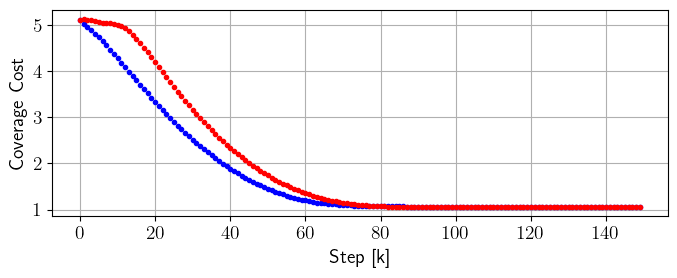

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[7,3])

cost_mu_0_arr = np.array(cost_mu_0_arr)
cost_mu_1000_arr = np.array(cost_mu_1000_arr)

cost_mu_0_mean = np.mean(cost_mu_0_arr, axis=0)
cost_mu_1000_mean = np.mean(cost_mu_1000_arr, axis=0)


cost_mu_0_std = np.std(cost_mu_0_arr, axis=0)
cost_mu_1000_std = np.std(cost_mu_1000_arr, axis=0)


plt.plot(np.arange(150), cost_mu_0_mean,'.', color = 'b', linewidth = 2)
plt.plot(np.arange(150), cost_mu_1000_mean,'.', color = 'r', linewidth = 2)
plt.fill_between(np.arange(150), cost_mu_0_mean - cost_mu_0_std, cost_mu_0_mean + cost_mu_0_std, color='b', alpha=.1)
plt.fill_between(np.arange(150), cost_mu_1000_mean - cost_mu_1000_std, cost_mu_1000_mean + cost_mu_1000_std, color='r', alpha=.1)
plt.grid()
plt.ylabel('Coverage Cost')
plt.xlabel('Step [k]')
plt.tight_layout()
#plt.savefig('coverage_cost.pdf')